TOPICOS QUE PODEM SER INTERESSANTES:
- Ver como se comportam as networks com palavras com mais que um significado.
- Existem networks, por exemplo, de cenas relacionadas com racismo? Se sim, pode ser usado para detenção. (MOTIFS)
- Falar de que temos um set de bues palavras mas um texto nao usa tantas palavras, procurar quantas palavras diferentes costuma ter um texto e criar uma random network com isso.
- Link Analysis

## FONTES LIVROS:

* The Fellowship Of The Ring: https://github.com/ganesh-k13/shell/blob/master/test_search/www.glozman.com/TextPages/01%20-%20The%20Fellowship%20Of%20The%20Ring.txt
* Lusiadas: https://github.com/rlafuente/textan/blob/master/sources/antero.txt
* Ode Triunfal: http://arquivopessoa.net/textos/2459
* Lusiadas - English Translation: https://www.gutenberg.org/files/32528/32528-h/32528-h.htm
* Memorial do Convento - https://docs.google.com/document/d/1vbG6B-OmWxcj1KaXeckznkoJWgtA5QprtyBucAQBtJM/edit?pli=1

In [13]:
import sys

# # Install requirements.txt
# !"{sys.executable}" -m pip install -r requirements.txt

# !python -m textblob.download_corpora

In [14]:
from scipy.optimize import curve_fit
from src.random_text import get_text as get_random_text
from src.text_to_network import get_network
from src.file_to_text import read_file
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import networkx as nx
import pandas as pd
import numpy as np
import random
import json

## Network Properties:

In order to compare all the networks, we're going to utilize the following metrics/properties:

1. Degree Distribuition + Average Degree: 

    É importante definir 3 situações: Um node só tem degree 1 se for um node no inicio ou no final de TODO o texto + não se repetindo. Um node tem degree 2 se for uma palavra que só se repete uma única vez no texto. Sempre que uma palavra se repete, terá sempre degree ímpar, considerando que se a palavra após for uma palavra que também estava após da mesma palavra numa recorrência anterior é considerada um novo edge.

    Probabilidade de haver um node com degree n > 2, num set de K palavras: $$P(k,n)=\frac{1}{\prod_{i=0}^{n-2}k-i}\times(\frac{1}{k})^{n}$$

2. Average Path Length + Diameter:

3. Clustering Coefficient:

4. Connected Components:
We're expecting to have one connected component for any big enough network, so we are not going to consider this metric to be a valid one for comparing networks

5. Subgraph distribution:
This may be a fingerprit of the author/publisher of the text. Further explore

6. Z-Score for most relevant motif

7. Degree Centrality

8. Betweeness Centrality

9. Shortest Path Distribution


In [15]:
from src.network_properties import EvaluateNetworks

evaluations = [
    'degree_distribution',
    'avg_path_length',
    'diameter',
    'clustering_coefficient',
    # 'z_score',
    'degree_centrality',
    'betweenness_centrality',
    'shortest_path_distribution',
]

## Understanding Real Network Example

We're going to analyze a real text (Fellowship of the ring) to first get a understanding of some underlying features that make a word adjacency network real.

After that, we'll try to build a model which generates a network similar to the real one.

### Reading the dataset

In [16]:
# Fellowship Of The Ring for random network definition purposes:
real_text = read_file('./data/The Fellowship Of The Ring.txt')

# number of words
n_words = len(real_text.words)
print('Fellowship Of The Ring has: ' + str(n_words) + ' words.')

# number of distinct words
n_distinct_words = len(set(real_text.words))
print('Fellowship Of The Ring has: ' + str(n_distinct_words) + ' distinct words.')

# Uniting all the words that were extracted creating what we called a "giga_phrase", a phrase that represents the entire book without paragraphs, periods or chapters
giga_phrase = ' '.join(real_text.words)
real_network = get_network(giga_phrase, weighted=False)

Fellowship Of The Ring has: 179543 words.
Fellowship Of The Ring has: 9131 distinct words.


### Network Properties

We're going to obtain all the properties using the class `EvaluateNetworks` defined in the file [./src/network_properties.py](./src/network_properties.py)

  <00.00 sec> Calculating: <degree_distribution>


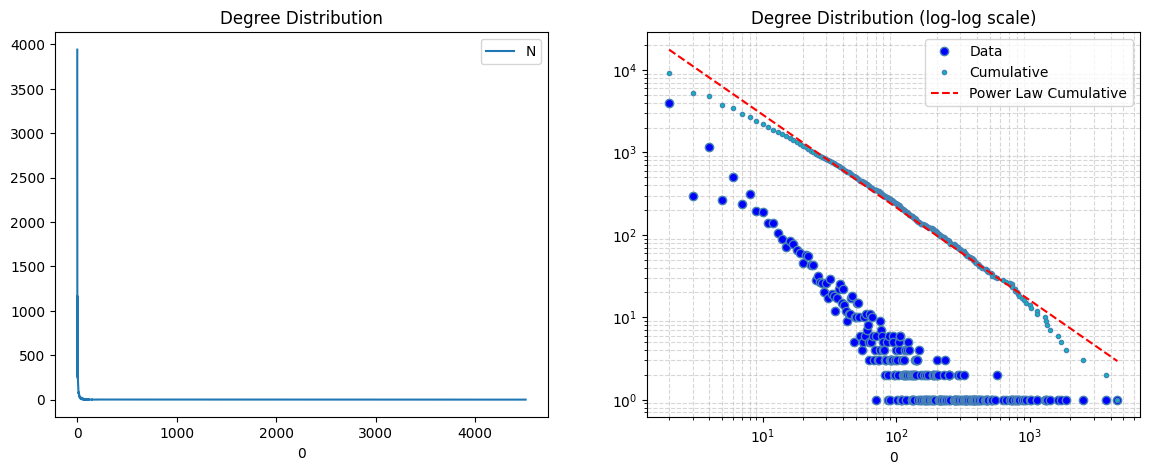

  <00.64 sec> Calculating: <avg_path_length>


    Finding Paths: 100%|██████████| 9131/9131 [03:13<00:00, 47.31it/s]


  <193.09 sec> Calculating: <diameter>
  <193.11 sec> Calculating: <clustering_coefficient>


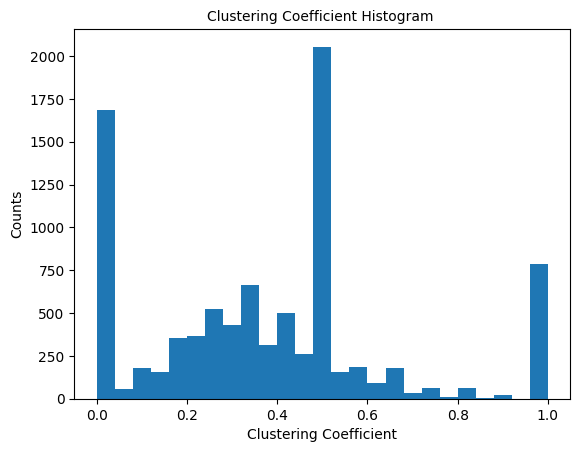

  <198.48 sec> Calculating: <degree_centrality>


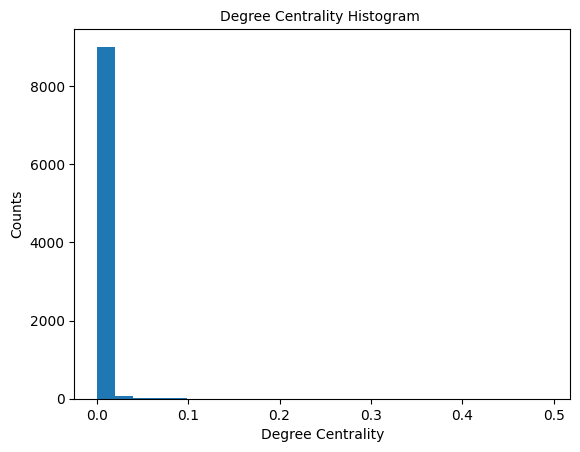

  <198.62 sec> Calculating: <betweenness_centrality>


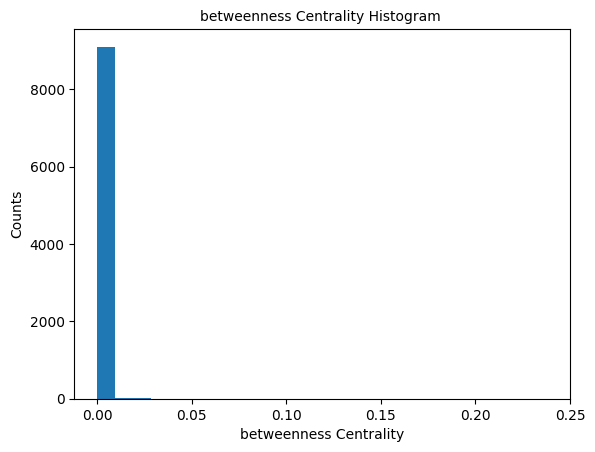

  <367.02 sec> Calculating: <shortest_path_distribution>


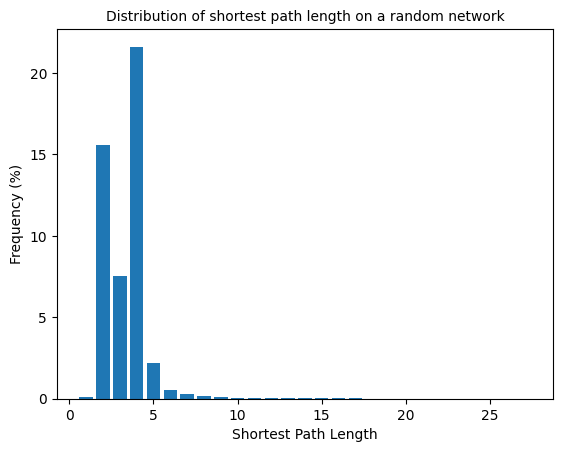

{'PowerLaw Exponent': -2.1275296446060405,
 'Average Degree': 17.090570583725768,
 'Average Path Length': 3.183700202989713,
 'Diameter': 27,
 'Average Clustering Coefficient': 0.3773981954450244,
 'Average Degree Centrality': 0.0018719135360050132,
 'Betweeness Centrality': 0.00023877617841485145}

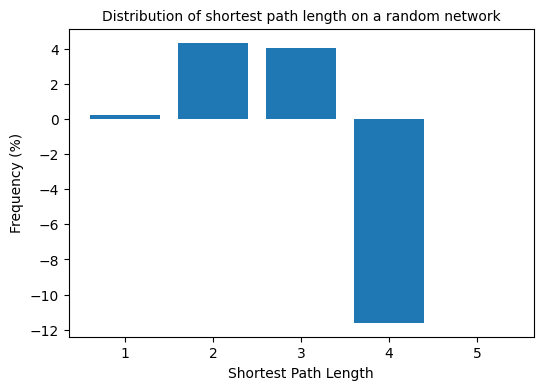

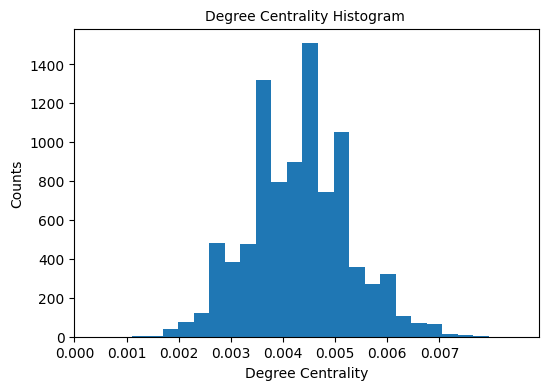

In [17]:
real = EvaluateNetworks(real_network, evaluations=evaluations)

# For betweenness centrality we're only using about 30% of nodes to speed up the process (by our tests, this gives very good approximation)
real.evaluate(plots=True, prints=False, betweenness_k=3000) 

### Visualizing the dataset

Visualizing the network using the `nx.draw` method from the library `networkx`. This gives us a brief understanding of what the network is like and allows us to more accurately choose models


In [ ]:
options = {
    'node_color': 'black',
    'node_size': 100,
    'width': 3,
}
nx.draw(real_network, **options)
plt.show()

## Network models

In this section, we'll try to experiment with different models to visualize if we can find a model which represents the word adjacency network (either generate the network directly, or by generating a text)

### Text Generating models

First we'll approach the model searching by generating random sentences using the English dictionary. In here we are trying to find some logic behind the text construction which may lead to a network similar to the real network. By finding a list of rules which generate a network similar to the real one, we may be able to generate a new language, or not, who knows?


#### Uniform Distribution

In this section, we'll analyze how a text where each word has been randomly selected behaves so that we can compare it with a actual network

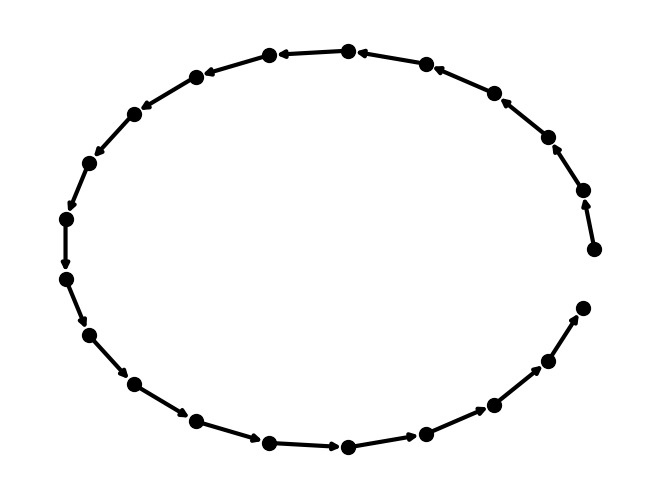

In [18]:
text = get_random_text(size=20)

network = get_network(text, weighted=False)

options = {
    'node_color': 'black',
    'node_size': 100,
    'width': 3,
}
nx.draw_circular(network, **options)
plt.show()

##### Brief Summary

After analyzing the above-generated network, we can conclude usual texts definitely behave differently than total randomness (as expected of humans).
We'll further try to improve this random word generator to further understand real-world word frequency networks

#### Power Law distribution

Very similar to the above section, but using a Power-law distribution for the word frequency instead of a uniform one.

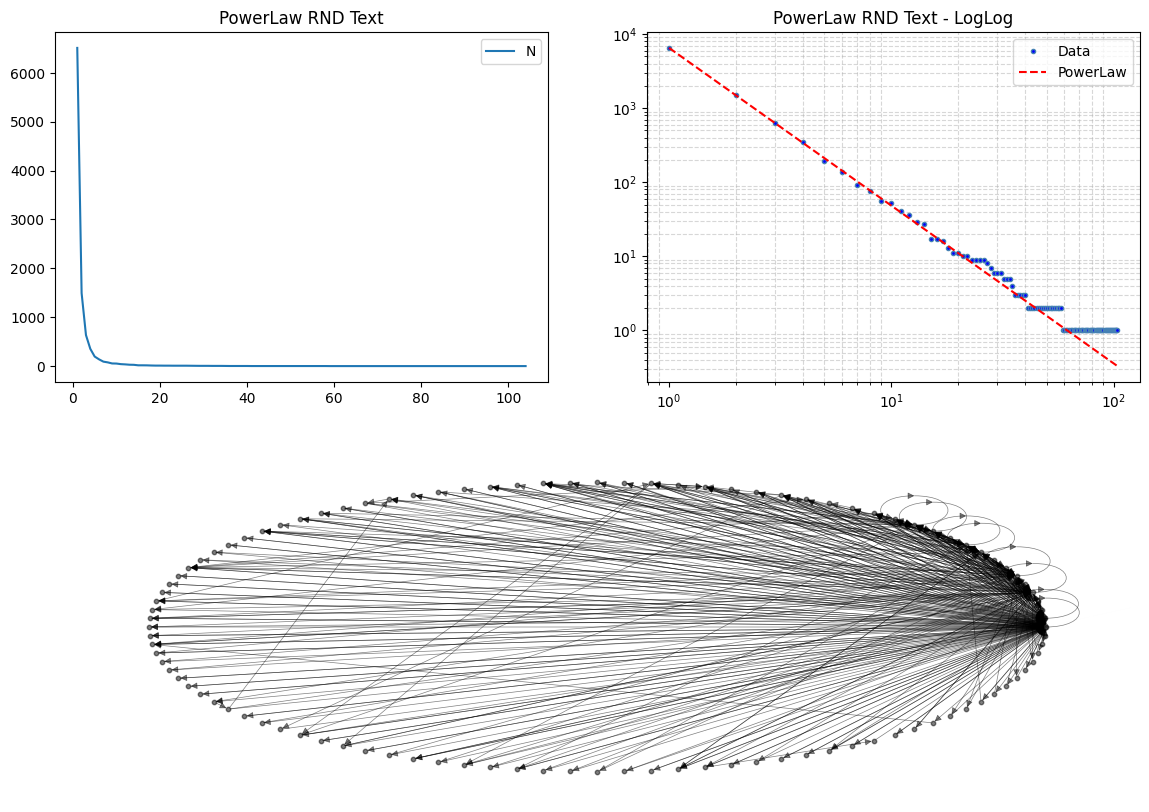

In [19]:
POWER_LAW_EXPONENT = 2.13

text = get_random_text(size=10000, power_law_exponent=POWER_LAW_EXPONENT)

# Verifying the text generated has word frequency obeying a power-law
frequencies = pd.DataFrame(text.split(" "))
frequencies['N'] = 0
frequencies = frequencies.groupby(by=[0]).count().sort_values(by=['N'], ascending=False).reset_index()

# In order to calculate logs, we need to start the index at 0, so adding 1 to all indexes
frequencies.index += 1
# Creating PowerLaw column
frequencies['PowerLaw'] = frequencies.apply(lambda row: frequencies['N'].iloc[0]*(row.name)**(-POWER_LAW_EXPONENT), axis=1)


gs = gridspec.GridSpec(2, 2, figure=plt.figure(figsize=(14, 10)))
ax = plt.subplot(gs[0, 1])
ax.grid(True, which="both", linestyle='--', alpha=0.5)
ax.tick_params(axis='both', which='major', labelsize=10)
ax.tick_params(axis='both', which='minor', labelsize=8)


# Normal scale
frequencies.plot(title='Word Frequency Dist', y='N', ax=plt.subplot(gs[0, 0]), xlabel=None)
# Log-log scale
frequencies.plot(
    title='Word Frequency Dist - LogLog'
    ,ax=ax
    ,loglog=True
    ,markersize=3
    ,markeredgecolor='steelblue'
    ,xlabel=None
    ,y=['N', 'PowerLaw']
    ,label=['Data', 'PowerLaw']
    ,style=['bo', 'r--']
)

# Plot network
network = get_network(text, weighted=False)
options = {
    'node_color': 'black',
    'node_size': 10,
    'width': 0.5,
    'alpha': 0.5,
}
nx.draw_circular(network, ax=plt.subplot(gs[1, :]), **options)

plt.show()

To try and understand a bit more if the network generated looks how a random text with power-law frequency distribution should behave, we're gonna scramble the words a few times and generate new networks to visualize the network generated.

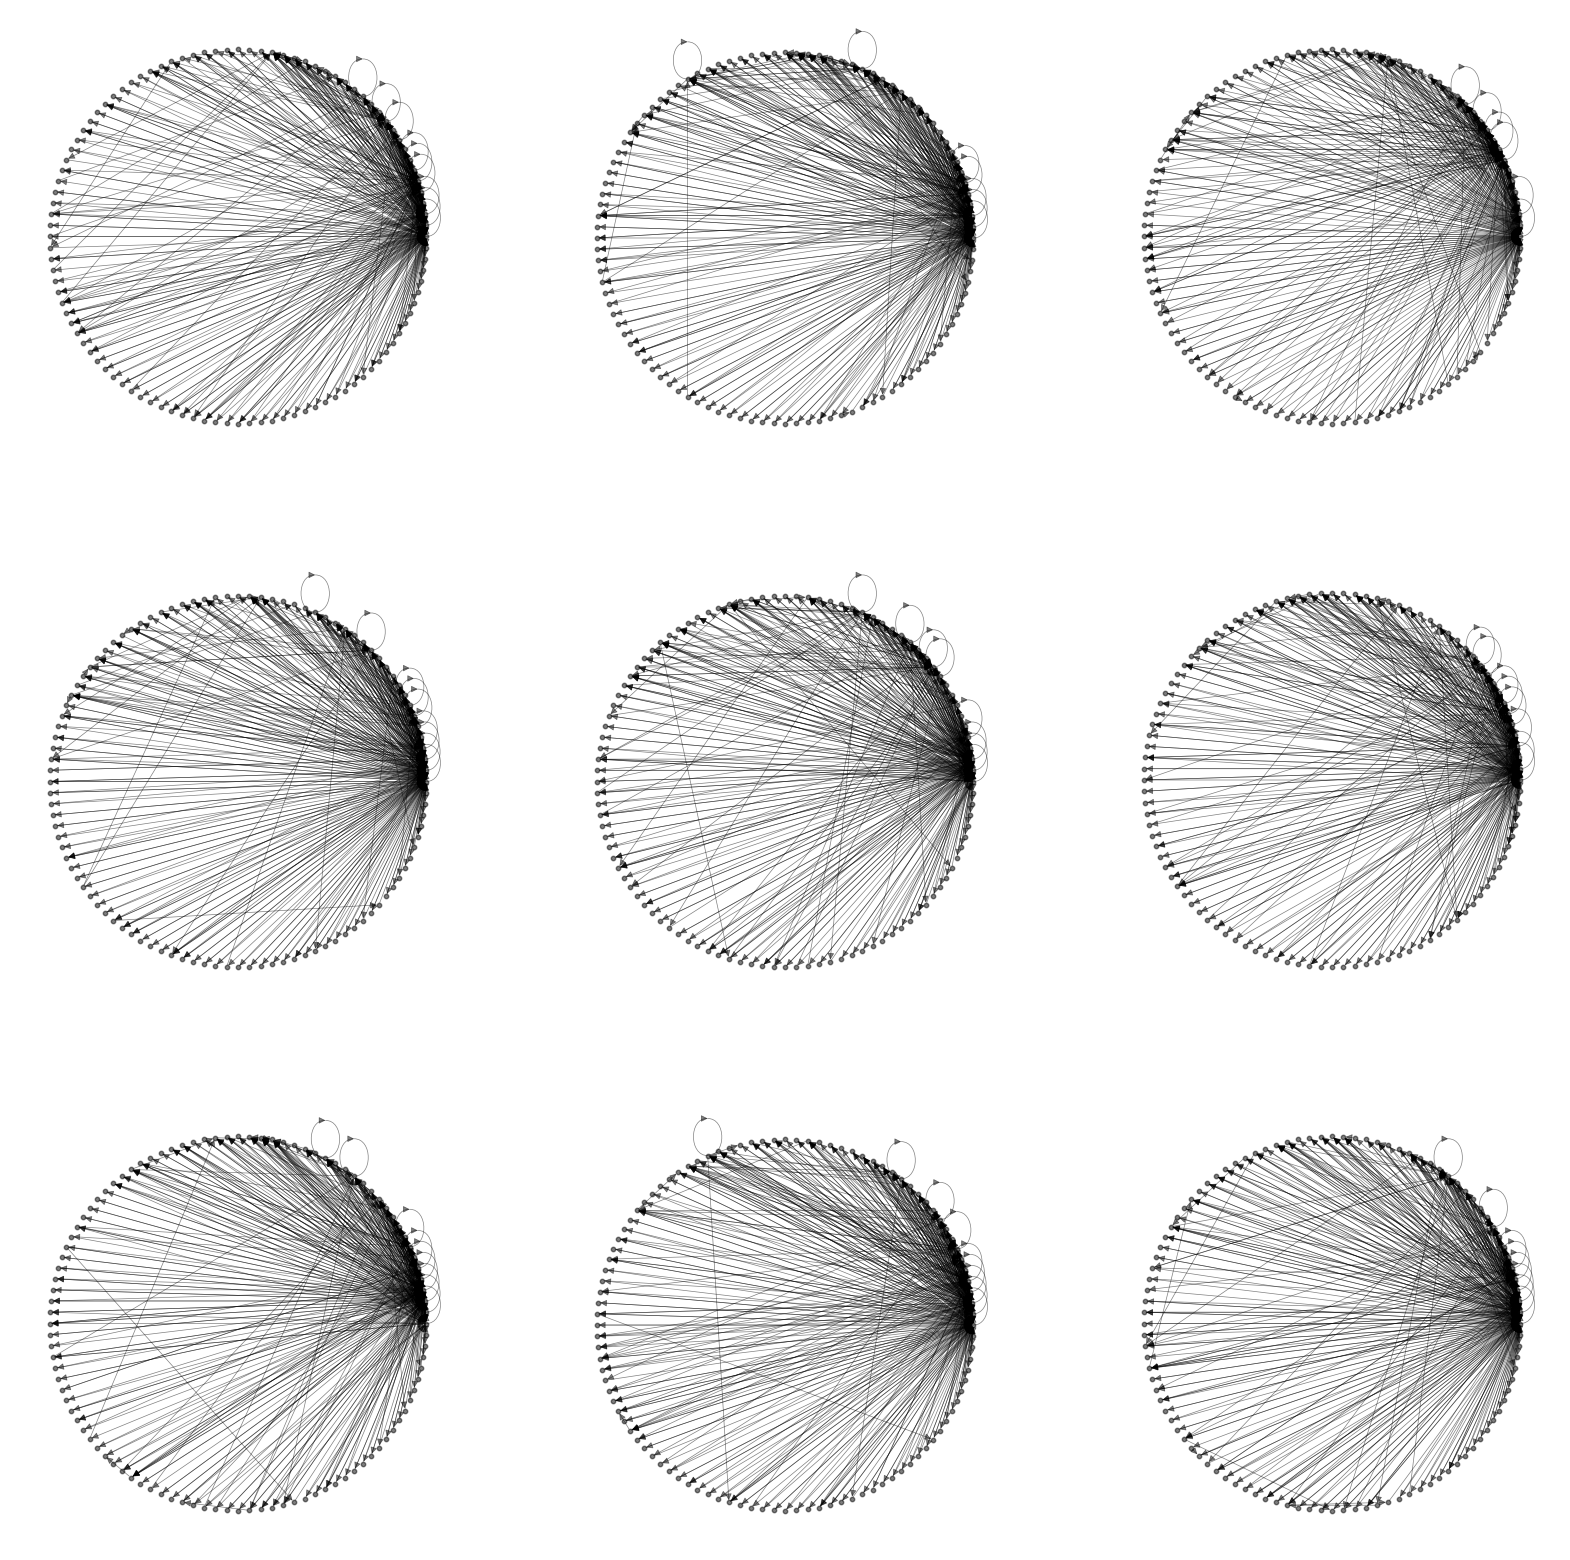

In [20]:
N_TRIES = 9
ncols = 3
# Using number of cols and total number of tries, generate number of rows
nrows = N_TRIES//ncols + min(1, N_TRIES%ncols)


aux = text.split(" ")

# Iterate through number of tries
(_, axs) = plt.subplots(ncols=ncols, nrows=nrows, figsize=(20,20))
for i in range(N_TRIES):
    random.shuffle(aux)

    network = get_network(' '.join(aux), weighted=False)
    nx.draw_circular(network, ax=axs[i//nrows][i%ncols], **options)

plt.show()

##### Brief Summary

After analyzing the above-generated networks, we can see that the well-known Power Law distribution is not enough to describe a real-world network for word adjacency.

This goes to show that human language is much more complex than what simple models may describe. We'll try to further improve our model to copy more properties of real-world texts to try and find a simple model which more accurately describes the real world word-adjacency networks. 

Another point to note:
* There exists self-loops with this model, we have to think of a way to remove this
* We need to add some way of creating ponctuation which separates words.
* Even though word frequency appears to follow a power-law distribution, there's more to it than that due to the fact that humans tend to try not to repeat words very frequently.

#### Using same words from real text

In this section we'll explore using the the real text but shuffling the words around to see what happens to the network

Average Path Length + Diameter

In [21]:
### Generating a random network keeping the same words

# getting n_distinct_"words"
number_set = [str(num) for num in random.sample(range(1, n_distinct_words + 1), n_distinct_words)]
# getting a combination of n_words with n_distinct_words as the base set
random_text = ' '.join(random.choices(number_set, k=n_words))
# generating the network as a list of tuples
network = get_network(random_text, weighted=False)

# average degree
avg_degree = np.mean([d for _, d in network.degree()])

Shortest Path Frequency Distribution

In [22]:

# Code from: https://networkx.org/nx-guides/content/exploratory_notebooks/facebook_notebook.html (with a bit of tuning)

shortest_path_lengths = dict(nx.all_pairs_shortest_path_length(network))
# Compute the average shortest path length for each node
average_path_lengths = [np.mean(list(spl.values())) for spl in shortest_path_lengths.values()]
# The average over all nodes
avg_path_lengths = np.mean(average_path_lengths)
# network diameter
diameter = max(nx.eccentricity(network, sp=shortest_path_lengths).values()) 
# We know the maximum shortest path length (the diameter), so create an array
# to store values from 0 up to (and including) diameter
path_lengths = np.zeros(diameter + 1, dtype=int)

# Extract the frequency of shortest path lengths between two nodes
for pls in shortest_path_lengths.values():
    pl, cnts = np.unique(list(pls.values()), return_counts=True)
    path_lengths[pl] += cnts

# Express frequency distribution as a percentage (ignoring path lengths of 0)
freq_percent = 100 * path_lengths[1:] / path_lengths[1:].sum()

# Plot the frequency distribution (ignoring path lengths of 0) as a percentage
fig, ax = plt.subplots(figsize=(6, 4))
ax.bar(np.arange(1, diameter + 1), height=freq_percent)
ax.set_title("Distribution of shortest path length on a random network", fontdict={"size": 10}, loc="center")
ax.set_xlabel("Shortest Path Length", fontdict={"size": 10})
ax.set_ylabel("Frequency (%)", fontdict={"size": 10})

Degree Centrality

In [ ]:
# degree centrality
degree_centrality = nx.centrality.degree_centrality(network)
# Compute the average degree centrality for each node
average_degree_centrality = np.mean(list(degree_centrality.values()))
# top 10 nodes by degree centrality
centrality = (sorted(degree_centrality.items(), key=lambda item: item[1], reverse=True))[:10]
print("These are the top 10 nodes with highest degree centrality:\n" + '\n'.join([f"{node} -> {centrality_value}" for node, centrality_value in centrality]))
# highest degre centrality node
highest_centrality = centrality[0][1]
# plot histogram
plt.figure(figsize=(6, 4))
plt.hist(degree_centrality.values(), bins=25)
plt.xticks(ticks=[0, 0.001, 0.002, 0.003, 0.004, 0.005, 0.006, 0.007])  # set the x axis ticks
plt.title("Degree Centrality Histogram ", fontdict={"size": 10}, loc="center")
plt.xlabel("Degree Centrality", fontdict={"size": 10})
plt.ylabel("Counts", fontdict={"size": 10})

plt.show()

These are the top 10 nodes with highest degree centrality:
6986 -> 0.008543263964950712
2847 -> 0.008105147864184009
206 -> 0.007886089813800658
3700 -> 0.007886089813800658
7968 -> 0.007667031763417306
1695 -> 0.007667031763417306
7526 -> 0.007667031763417306
2307 -> 0.007667031763417306
7767 -> 0.007447973713033954
7824 -> 0.007447973713033954


Text(0, 0.5, 'Counts')

Betweenness Centrality

In [ ]:
# betweenness centrality
betweenness_centrality = nx.centrality.betweenness_centrality(network)
# top 10 nodes by betweenness centrality
centrality = (sorted(betweenness_centrality.items(), key=lambda item: item[1], reverse=True))[:10]
print("These are the top 10 nodes with highest betweenness centrality:\n" + '\n'.join([f"{node} -> {centrality_value}" for node, centrality_value in centrality]))
# highest degre centrality node
highest_centrality = centrality[0][1]
# plot histogram
plt.figure(figsize=(6, 4))
plt.hist(betweenness_centrality.values(), bins=25)
plt.xticks(ticks=[0, 0.0001, 0.0002, 0.0003, 0.0004, 0.0005, 0.0006, 0.0007, 0.0008, 0.0009, 0.001])  # set the x axis ticks
plt.title("betweenness Centrality Histogram ", fontdict={"size": 10}, loc="center")
plt.xlabel("betweenness Centrality", fontdict={"size": 10})
plt.ylabel("Counts", fontdict={"size": 10})

plt.show()

KeyboardInterrupt: 

Random Analysis

In [ ]:
def random_analysis(n):
    avg_list = []
    avg_path_lengths_list = []
    diameter_list = []
    avg_degree_centrality_list = []

    # Create a new figure for avg_list
    fig_avg, ax_avg = plt.subplots()

    # Create a new figure for avg_degree_centrality_list
    fig_degree, ax_degree = plt.subplots()

    # Create a new figure for avg_path_lengths_list
    fig_path_length, ax_path_length = plt.subplots()

    # Create a new figure for diameter_list
    fig_diameter, ax_diameter = plt.subplots()

    for i in range(n):
        # generate a random network for the current step
        number_set = [str(num) for num in random.sample(range(1, n_distinct_words + 1), n_distinct_words)]
        random_text = ' '.join(random.choices(number_set, k=n_words))
        network = get_network(random_text, weighted=False)
        # calculate the average degree
        avg_degree = np.mean([d for _, d in network.degree()])
        # calculate the average shortest path
        shortest_path_lengths = dict(nx.all_pairs_shortest_path_length(network))
        average_path_lengths = [np.mean(list(spl.values())) for spl in shortest_path_lengths.values()]
        avg_path_lengths = np.mean(average_path_lengths)
        # calculate the diameter
        diameter = max(nx.eccentricity(network, sp=shortest_path_lengths).values()) 
        # calculate average degree centrality
        degree_centrality = nx.centrality.degree_centrality(network)
        average_degree_centrality = np.mean(list(degree_centrality.values()))
        # add the values to their lists
        avg_list.append(avg_degree)
        avg_path_lengths_list.append(avg_path_lengths)
        diameter_list.append(diameter)
        avg_degree_centrality_list.append(average_degree_centrality)

    # Set y-axis label
    ax_avg.set_ylabel('Value')
    ax_degree.set_ylabel('Value')
    ax_path_length.set_ylabel('Value')
    ax_diameter.set_ylabel('Value')

    # Set plot title
    ax_avg.set_title('avg_degree')
    ax_degree.set_title('avg_degree_centrality')
    ax_path_length.set_title('avg_path_length')
    ax_diameter.set_title('avg_diameter')

    # Plot avg_list in fig_avg
    ax_avg.boxplot(avg_list)

    # Plot avg_degree_centrality_list in fig_degree
    ax_degree.boxplot(avg_degree_centrality_list)

    # Plot avg_path_lengths_list in fig_path_length
    ax_path_length.boxplot(avg_path_lengths_list)

    # Plot diameter_list in fig_diameter
    ax_diameter.boxplot(diameter_list)

    # Display the plots
    plt.show()


# random_analysis(100)

## Real Network Analysis

In this section, we'll try to analyze and summarize some of the real networks we found (some portuguese, some english some french).

The full list of books/texts analyzed is:

* Lusiadas by Luis de Camoes (Portuguese)
* Lusiadas (English Translation) by Luis de Camoes, translated by William Julius Mickle (English)
* Memorial do Convento by Jose Saramago (Portuguese)
* Ode Triunfal by Fernando Pessoa (Portuguese)
* The Fellowship of The Ring by J. R. R. Tolkien (English)

In order to analyze and better understand the underlying structure of each network, we generated 10 random networks for all the different models defined in the above section and calculated the averages of the metrics for those generated networks.

With this data, we're able to compare the metrics of the networks to a random network which contains some of the same features. By using this approach, we are able to identify the specific characteristics that are specific to real world networks.

In [ ]:
# Evaluation Metrics

evaluations = [
    'degree_distribution',
    'avg_path_length',
    'diameter',
    'clustering_coefficient',
    #'z_score',
    'degree_centrality',
    'betweenness_centrality'
]

In [ ]:
with open('./data/books_metadata.json', 'r') as f:
    books = json.load(f)


for book in books.keys():
    print(f'Evaluation "{book}"...')
    # Get TextBlob from file
    text = read_file(f'./data/{book}.txt', encoding='utf-8')

    # Transform text into network
    network = get_network(' '.join(text.words), weighted=False)
    
    # Number of Nodes + Number of Word + Number of Edges
    books[book].update(
        {'#Nodes': len(set(text.words)), 
         '#Words': len(text.words),
         '#Edges': len(network.edges)
    })    
    # Add evaluation metrics to dictionary
    books[book].update(EvaluateNetworks(network, evaluations=evaluations).evaluate(plots=False, prints=False))

df = pd.DataFrame.from_dict(books, orient='index').reset_index(drop=False).rename(columns={'index':'Book'})

df